# Модель логистической регрессии

## Импорт необходимых библиотек и модулей

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import train_test_split
import joblib
import json
from sklearn.impute import SimpleImputer

## Загружаем предобработанные данные, смотрим распределение классов.
* Target в данных составляет всего 3%, что говорит о сильном дисбалансе классов. Учитываем это в дальнейшем (class_weight='balanced', stratify=y).
* Загружаем только 300_000 случайных строк для грида.

In [2]:
# === ПУТИ ===
DATA_ROOT = '/home/jupyter/project/processed_data_1'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')

# === ЗАГРУЗКА ===
df_grid = pd.read_parquet(os.path.join(TRAIN_DIR, 'final_train.parquet'))
df_grid = df_grid.sample(n=300_000, random_state=42)
print(f"✅ Загружено {len(df_grid):,} строк")

# === ПРОВЕРИМ РАСПРЕДЕЛЕНИЕ КЛАССОВ ===
print(df_grid['flag'].value_counts(normalize=True))

# === Фичи и таргет ===
y = df_grid['flag'].values
X = df_grid.drop(columns=['flag', 'id'])
print(f"Размер X: {X.shape}, y: {y.shape}")


✅ Загружено 300,000 строк
0    0.964587
1    0.035413
Name: flag, dtype: float64
Размер X: (300000, 428), y: (300000,)


## GRID SEARCH для LogisticRegression.
* Гиперпараметры используем solver='saga' - подходит для больших матриц и поддерживает class_weight='balanced'. random_state=42 указываем для сходимости.

In [3]:
# === PIPELINE ===
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ('clf', LogisticRegression(
        solver='saga',
        max_iter=500,
        class_weight='balanced',
        random_state=42
    ))
])

# === ПАРАМЕТРЫ ДЛЯ ГРИДА ===
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 3.0],
    'clf__penalty': ['l2']
}

# === GRID SEARCH ===
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
grid.fit(X, y)

print("\n=== РЕЗУЛЬТАТЫ GRIDSEARCH ===")
print("Лучшие параметры:", grid.best_params_)
print(f"ROC-AUC (CV): {grid.best_score_:.5f}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=14.3min
[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=14.2min
[CV] END ........................clf__C=1.0, clf__penalty=l2; total time=14.3min
[CV] END .......................clf__C=0.01, clf__penalty=l2; total time=14.3min
[CV] END ........................clf__C=1.0, clf__penalty=l2; total time=14.3min
[CV] END ........................clf__C=3.0, clf__penalty=l2; total time=14.3min
[CV] END .......................clf__C=0.01, clf__penalty=l2; total time=14.3min
[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=14.3min
[CV] END ........................clf__C=3.0, clf__penalty=l2; total time=14.4min
[CV] END .......................clf__C=0.01, clf__penalty=l2; total time=14.3min
[CV] END ........................clf__C=1.0, clf__penalty=l2; total time=14.4min
[CV] END ........................clf__C=3.0, clf__penalty=l2; total time=14.3min

=== РЕЗУЛЬТАТЫ GRIDSEARCH =

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Получив лучшие параметры на GRID SEARCH применим их на текущей выборке строк для оценки модели

In [4]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# === TRAIN/TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

# === ЛУЧШАЯ МОДЕЛЬ ===
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

# === ПРОГНОЗ ===
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# === МЕТРИКИ ===
roc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)
print("\n=== ОЦЕНКА МОДЕЛИ ===")
print(f"ROC-AUC: {roc:.5f}")
print("Confusion matrix:")
print(cm)
print("\nОтчёт:")
print(classification_report(y_test, y_pred, digits=4))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



=== ОЦЕНКА МОДЕЛИ ===
ROC-AUC: 0.73507
Confusion matrix:
[[39442 18433]
 [  697  1428]]

Отчёт:
              precision    recall  f1-score   support

           0     0.9826    0.6815    0.8048     57875
           1     0.0719    0.6720    0.1299      2125

    accuracy                         0.6812     60000
   macro avg     0.5273    0.6768    0.4674     60000
weighted avg     0.9504    0.6812    0.7809     60000



## Сохраняем параметры в файл. 
* Параметры получились не плохие, хоть и недостаточные для выполнения задания (необходимо ROC-AUC выше 0.75). Для логистической регрессии очень хорошо

In [5]:
# Сохраним параметры
params_path = os.path.join(DATA_ROOT, 'logreg_best_params.json')
with open(params_path, 'w') as f:
    json.dump(grid.best_params_, f, indent=4)
print(f"✅ Параметры сохранены: {params_path}")

✅ Параметры сохранены: /home/jupyter/project/processed_data_1/logreg_best_params.json


## Обучаем логистическую регрессию на всех данных используя лучшие параметры и выводим метрики

✅ final shape: (3000000, 430)
✅ Загружены лучшие параметры из /home/jupyter/project/processed_data_1/logreg_best_params.json: {'C': 0.01, 'penalty': 'l2'}

🚀 Обучаем финальную логистическую регрессию на всех данных...
✅ Модель обучена.

📊 Оценка на тесте:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



ROC-AUC: 0.7353

Отчёт классификации:
              precision    recall  f1-score   support

           0     0.9831    0.6744    0.8000    578712
           1     0.0719    0.6856    0.1301     21288

    accuracy                         0.6748    600000
   macro avg     0.5275    0.6800    0.4651    600000
weighted avg     0.9508    0.6748    0.7762    600000


Матрица ошибок:
[[390273 188439]
 [  6694  14594]]


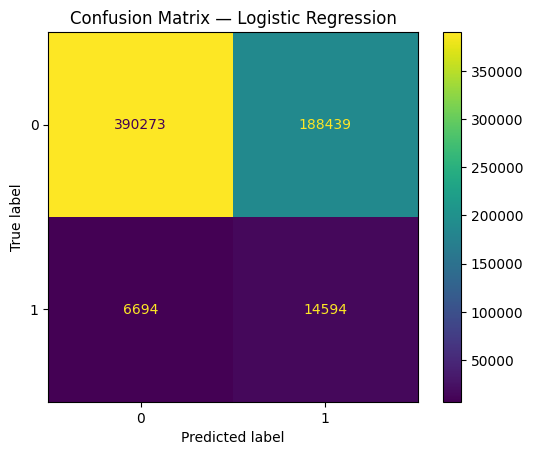

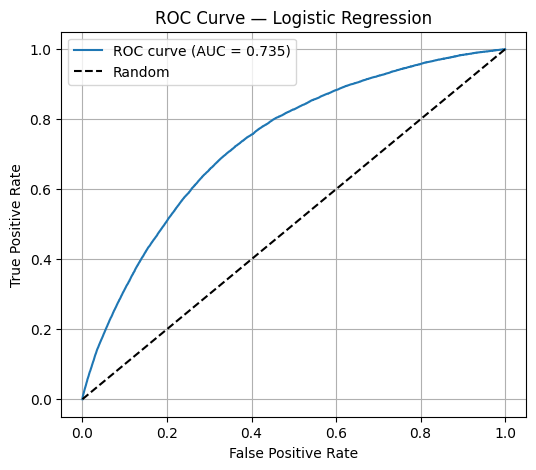


💾 Модель сохранена в: /home/jupyter/project/processed_data_1/final_logreg_model.pkl


In [2]:
DATA_ROOT = '/home/jupyter/project/processed_data_1'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
PARAMS_PATH = os.path.join(DATA_ROOT, 'logreg_best_params.json')  # файл с лучшими параметрами
MODEL_PATH = os.path.join(DATA_ROOT, 'final_logreg_model.pkl')
TARGET_COL = 'flag'
# === 1. ЗАГРУЗКА  ФАЙЛОВ ===
final = pd.read_parquet(os.path.join(TRAIN_DIR, 'final_train.parquet'))
print(f"✅ final shape: {final.shape}")

# === 3. РАЗДЕЛЕНИЕ ===
X = final.drop(['id', 'flag'], axis=1)
y = final['flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=12, 
                                                    stratify=y, shuffle=True)

del final, X, y
gc.collect()


# === 4. ЗАГРУЗКА ЛУЧШИХ ПАРАМЕТРОВ ===
if os.path.exists(PARAMS_PATH):
    with open(PARAMS_PATH, 'r') as f:
        best_params = json.load(f)
    # убираем возможные префиксы вроде 'clf__' или 'model__'
    best_params = {k.split('__')[-1]: v for k, v in best_params.items()}
    print(f"✅ Загружены лучшие параметры из {PARAMS_PATH}: {best_params}")
else:
    print("⚠️ Не найден файл с параметрами, используются дефолтные.")
    best_params = {"C": 1.0, "penalty": "l2", "solver": "lbfgs"}

# === 5. СОЗДАНИЕ ПАЙПЛАЙНА ===
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("model", LogisticRegression(solver='saga', max_iter=500, class_weight="balanced", **best_params))
])

# === 6. ОБУЧЕНИЕ ===
print("\n🚀 Обучаем финальную логистическую регрессию на всех данных...")
pipe.fit(X_train, y_train)
print("✅ Модель обучена.")

# === 7. ПРОВЕРКА НА ТЕСТЕ ===
print("\n📊 Оценка на тесте:")
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC-AUC: {roc_auc:.4f}")
print("\nОтчёт классификации:")
print(classification_report(y_test, y_pred, digits=4))
print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred))


# === 8. ВИЗУАЛИЗАЦИЯ CONFUSION MATRIX ===
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

# === 9. ROC-КРИВАЯ ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

# === 10. СОХРАНЕНИЕ МОДЕЛИ ===
joblib.dump(pipe, MODEL_PATH)
print(f"\n💾 Модель сохранена в: {MODEL_PATH}")

# ROC-AUC: 0.7353 после обучения на всех данных. Согласно recall мы пропустили около трети всех мошенников и определили достаточно много людей мошенниками ложно, но последнее не так страшно для данной задачи.